In [ ]:
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.all import *
from torchvision.transforms import Grayscale, ToTensor
import pandas as pd

# Exercise 1

Try creating a fully convolutional net with adaptive average pooling for MNIST (note that you'll need fewer stride-2 layers). How does it compare to a network without such a pooling layer?

## Import & explore dataset sample

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [ ]:
three_path = (path/'train'/'3').ls().sorted()
image = Image.open(three_path[1])
array(image).shape

(28, 28)

In [ ]:
for num_path in (path/'train').ls():
  print(f"{num_path} : {len((path/'train'/'3').ls().sorted())}")

/root/.fastai/data/mnist_sample/train/3 : 6131
/root/.fastai/data/mnist_sample/train/7 : 6131


## Creating dataloaders

In [ ]:
class ToGrayscale(Transform):
    def encodes(self, img: PILImage):
        return img.convert('L')

In [ ]:
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    seed=42,
    item_tfms=[Resize(28), ToGrayscale()],
    batch_tfms=Normalize.from_stats(0.5, 0.5),
    bs=64
)

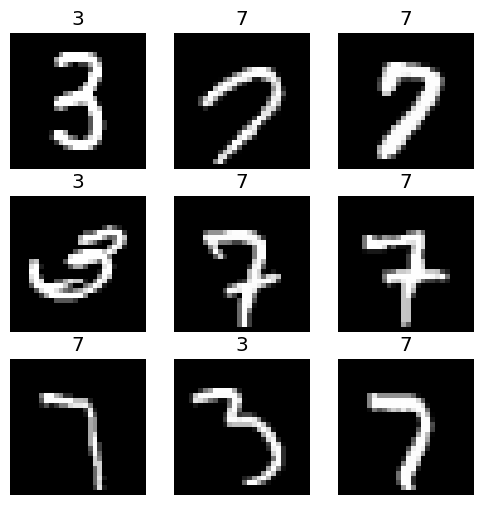

In [ ]:
dls.show_batch(max_n=9, figsize=(6, 6), cmap='gray')

## Model definition

In [ ]:
def get_model(nb_classes):
  return nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
      nn.Linear(64, nb_classes)
  )

## Training

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.010964781977236271)

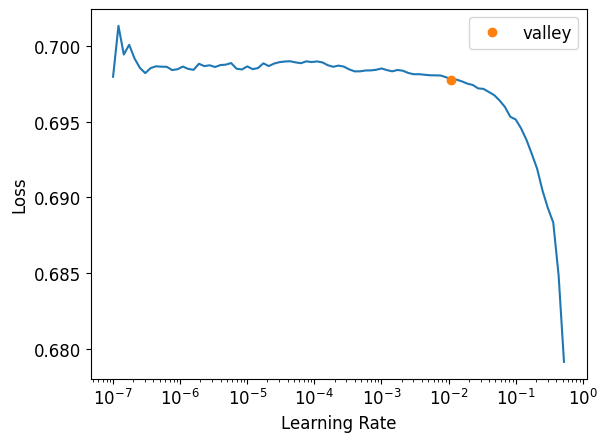

In [ ]:
nb_classes = 2

learner = Learner(dls, get_model(nb_classes), opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.676707,0.661188,0.683023,00:22
1,0.446782,0.339670,0.933759,00:26
2,0.195052,0.181473,0.944553,00:29
3,0.169856,0.168105,0.942591,00:35
4,0.159214,0.166769,0.942591,00:24


We obtain 94% precision after 5 epochs, time to evaluate on full MNIST dataset.

## Using full dataset

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

SuggestedLRs(valley=0.17378008365631104)

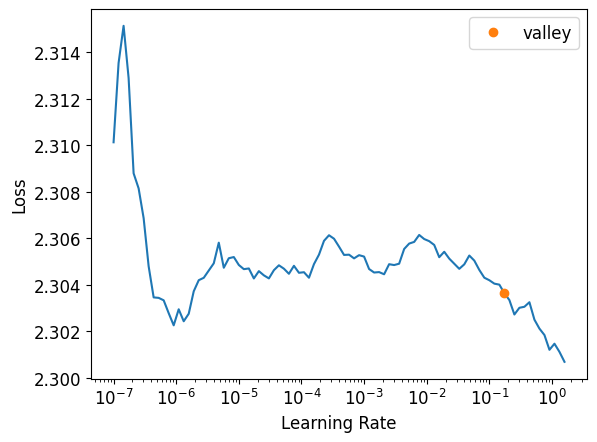

In [ ]:
dls = ImageDataLoaders.from_folder(
    path,
    train='training',
    valid='testing',
    seed=42,
    item_tfms=[Resize(28), ToGrayscale()],
    batch_tfms=Normalize.from_stats(0.5, 0.5),
    bs=64
)

nb_classes = 10

learner = Learner(dls, get_model(nb_classes), opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.611445,1.556832,0.484800,02:23
1,1.428231,1.418207,0.546300,02:21
2,1.377181,1.394088,0.559300,02:11
3,1.351807,1.362250,0.562100,01:55
4,1.346054,1.357139,0.560300,01:55


In [ ]:
non_adaptive_model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.Flatten(),
      nn.Linear(64*4*4, nb_classes)
  )

learner = Learner(dls, non_adaptive_model, opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learner.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.362456,0.332105,0.904100,01:57
1,0.332155,0.310618,0.911000,01:52
2,0.291237,0.288630,0.917400,01:55
3,0.297254,0.279058,0.921800,01:56
4,0.276323,0.274193,0.922300,01:52


In both cases 5 epochs isn't enough to see signs of overfitting.

|            | with adaptive pooling | without |
|:----------|:----------:|:----------:|
| precision (5 epochs) | 56,2% | 92,2% |  
  
Adaptive average pooling isn't adapted to the MNIST use case as it reduces drastically the features used by the last dense layer to classify the written number.

In [ ]:
learner.export('non_adaptive_model.pkl')

In [ ]:
# learner = load_learner('non_adaptive_model.pkl')
img = Image.open(((path/'testing'/'8').ls())[0])
img

In [ ]:
pred, _, prob = learner.predict(img)
pred, prob

("['7', '1', '0', '8', '0', '2', '8', '7', '7', '0']",
 tensor([-3.5389,  1.8387, -0.1615, -2.0916,  0.4624,  2.1341, -2.6239, -3.0342,  7.4652,  0.6051]))

# Exercise 2

In *chapter_foundations* we introduce Einstein summation notation. Skip ahead to see how this works, and then write an implementation of the 1×1 convolution operation using torch.einsum. Compare it to the same operation using torch.conv2d.

# Exercise 3

Write a "top-5 accuracy" function using plain PyTorch or plain Python.

In [ ]:
def top5_accuracy(preds, targets):
  probs = torch.softmax(preds, dim=-1) # (Batch, Classes)
  top5_idx = torch.topk(probs, 5, dim=-1)[1] # (Batch, 5)
  targets = targets.unsqueeze(-1) # (Batch, 1)
  in_top5 = (top5_idx == targets).any(dim=1)
  return in_top5.float().mean()

# Exercise 4

Train a model on Imagenette for more epochs, with and without label smoothing. Take a look at the Imagenette leaderboards and see how close you can get to the best results shown. Read the linked pages describing the leading approaches.